In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [80]:
!pip install tensorflow

In [92]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [13]:
data= pd.read_csv('BTC_USD_Price_Prediction_Data.csv')

In [15]:
data.head()

,Unnamed: 0,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,0,BTC,2014-03-14,124.65499,125.30466,125.75166,123.56349
1,1,BTC,2014-03-15,126.45500,124.65499,126.75850,124.63383
2,2,BTC,2014-03-16,109.58483,126.45500,126.66566,84.32833
3,3,BTC,2014-03-17,119.67466,109.58483,119.67500,108.05816
4,4,BTC,2014-03-18,122.33866,119.67466,122.93633,119.00566


In [19]:
print(data.dtypes)

Unnamed: 0               int64
Currency                object
Date                    object
Closing Price (USD)    float64
24h Open (USD)         float64
24h High (USD)         float64
24h Low (USD)          float64
dtype: object


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2787 entries, 0 to 2786
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2787 non-null   int64  
 1   Currency             2787 non-null   object 
 2   Date                 2787 non-null   object 
 3   Closing Price (USD)  2787 non-null   float64
 4   24h Open (USD)       2787 non-null   float64
 5   24h High (USD)       2787 non-null   float64
 6   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 152.5+ KB


In [23]:
#Verification de variable manquante
data.isnull().sum()

Unnamed: 0             0
Currency               0
Date                   0
Closing Price (USD)    0
24h Open (USD)         0
24h High (USD)         0
24h Low (USD)          0
dtype: int64

In [25]:
data.describe()

,Unnamed: 0,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
count,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000
mean,1393.000000,6530.845141,6514.579485,6711.061683,6303.417386
std,804.681925,10887.847444,10863.800772,11206.779756,10475.811252
min,0.000000,109.584830,109.584830,119.675000,84.328330
25%,696.500000,461.087500,460.400500,470.720995,451.818830
50%,1393.000000,2781.182500,2773.367500,2875.696250,2697.457500
75%,2089.500000,8507.923720,8497.887593,8764.291985,8222.060570
max,2786.000000,63347.789035,63563.673545,64802.787870,62095.632914


In [29]:
#Supprimons les colonnes inutiles
#On a deja une colonne qui s'occupe de l'index donc la colonne unnamed est inutile et on s'est qu'on travail sur le BTC donc la colonne currency est inutile aussi
data_cleaned= data.drop(['Unnamed: 0', 'Currency'], axis=1)




In [33]:
#On converti la colonne Date en format datetime
data_cleaned['Date']= pd.to_datetime(data_cleaned['Date'])

In [35]:
#On  trie notre dataset par date
data_cleaned= data_cleaned.sort_values(by='Date').reset_index(drop=True)

In [47]:
#Normalisons nos colonnes numériques
scaler=MinMaxScaler()
scaled_values= scaler.fit_transform(data_cleaned[['Closing Price (USD)', '24h Open (USD)', '24h High (USD)','24h Low (USD)']])




In [49]:
#Data normalisé
dt_norm= pd.DataFrame(scaled_values, columns=['Closing Price (USD)', '24h Open (USD)', '24h High (USD)','24h Low (USD)'])


In [51]:
#Ajout de la colonne 'Date' pour reference
dt_norm['Date']= data_cleaned['Date']

print (dt_norm.head())

   Closing Price (USD)  24h Open (USD)  24h High (USD)  24h Low (USD)  \
0             0.000238        0.000248        0.000094       0.000633   
1             0.000267        0.000237        0.000110       0.000650   
2             0.000000        0.000266        0.000108       0.000000   
3             0.000160        0.000000        0.000000       0.000383   
4             0.000202        0.000159        0.000050       0.000559   

        Date  
0 2014-03-14  
1 2014-03-15  
2 2014-03-16  
3 2014-03-17  
4 2014-03-18  


**Preparation LSTM**

In [55]:
#Définir la taille de la fenetre temporelle
window_size=30

In [59]:
#Listes pour les entrées (X) et les sorties (y)
X, y = [ ], [ ]

#Creoons les sequences temporelles
for i in range(len(dt_norm)-window_size):
    X.append(dt_norm.iloc[i:i+ window_size, : -1].values)
    y.append(dt_norm.iloc[i+window_size, 0])


In [61]:
#On conveertir en arrays numpy
X= np.array(X)
y= np.array(y)

In [67]:
#Divisons notre ensemble d'entrainement et de test 
train_size= int (0.8*len(X))
X_train, X_test= X[: train_size], X[train_size:]
y_train, y_test= y[: train_size], y[train_size:]

**LSTM**

In [94]:
# On Définis l'entrée du modèle
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

In [102]:
#Creaton du modele
model_lstm= Sequential([
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

In [104]:
#On compile notre modele
model_lstm.compile(optimizer= 'adam', loss=' mean_squared_error')

Prediction & Evaluation du modele LSTM

In [114]:
#prediction
y_pred_lstm= model_lstm.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [116]:
#Calculons l'erreur moyenne quadratique (MSE)

from sklearn.metrics import mean_squared_error
mse= mean_squared_error(y_test, y_pred_lstm)
print (f"Erreur Moyenne Quadratique(MSE): {mse}")

Erreur Moyenne Quadratique(MSE): 0.28052613603096627


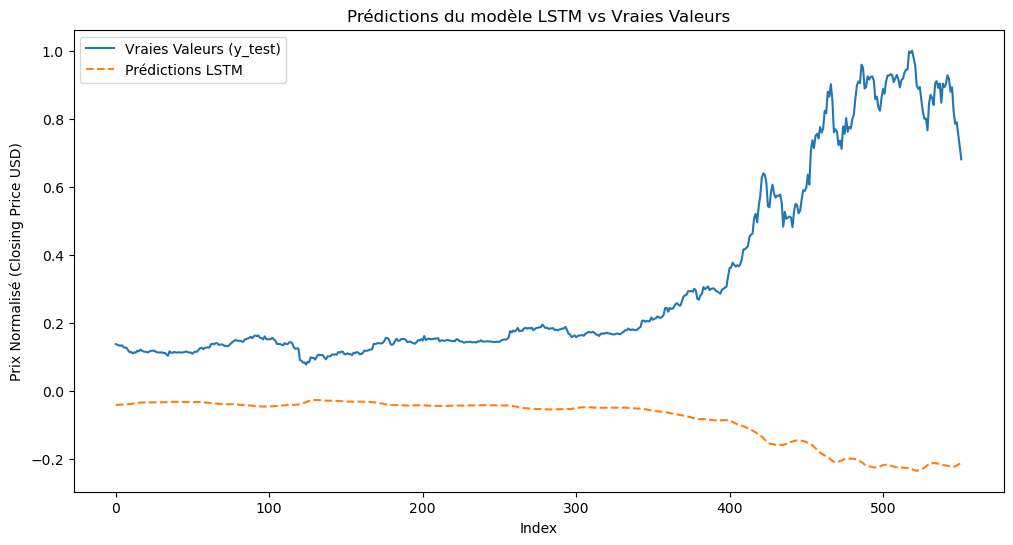

In [150]:
 #Visualiser les prédictions du modèle LSTM
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Vraies Valeurs (y_test)')
plt.plot(y_pred_lstm, label='Prédictions LSTM', linestyle='dashed')
plt.title('Prédictions du modèle LSTM vs Vraies Valeurs')
plt.xlabel('Index')
plt.ylabel('Prix Normalisé (Closing Price USD)')
plt.legend()
plt.savefig('LSTM.png', dpi=300)
plt.show()
 

**Apprentissage incremental avec SGDRegressor**

In [122]:
from sklearn.linear_model import SGDRegressor

#On initialise le modele incremental
model_sgd= SGDRegressor(max_iter=1, tol=None, learning_rate='adaptive', eta0= 0.001, random_state=42)

In [134]:
#On choisir la taille de batch pour l'apprentissage incréemtal
batch_size= 50
n_batches= len(X_train)// batch_size

In [136]:
#Entrainement de notre modele
for batch_index in range (n_batches):
    start= batch_index*batch_size
    end= start+ batch_size

    X_batch =X_train[start:end].reshape(batch_size, -1) #Aplatir chaque seance en vecteur
    y_batch= y_train[start:end]

    model_sgd.partial_fit(X_batch, y_batch)

In [138]:
#Evaluation sur l'ensemble de test
X_test_flat= X_test.reshape (X_test.shape[0], -1)
y_pred_sgd= model_sgd.predict(X_test_flat)

In [140]:
# Calcul de l'erreur
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
print(f"Erreur Moyenne Quadratique (MSE) - SGDRegressor : {mse_sgd}")

Erreur Moyenne Quadratique (MSE) - SGDRegressor : 0.012476090388495344


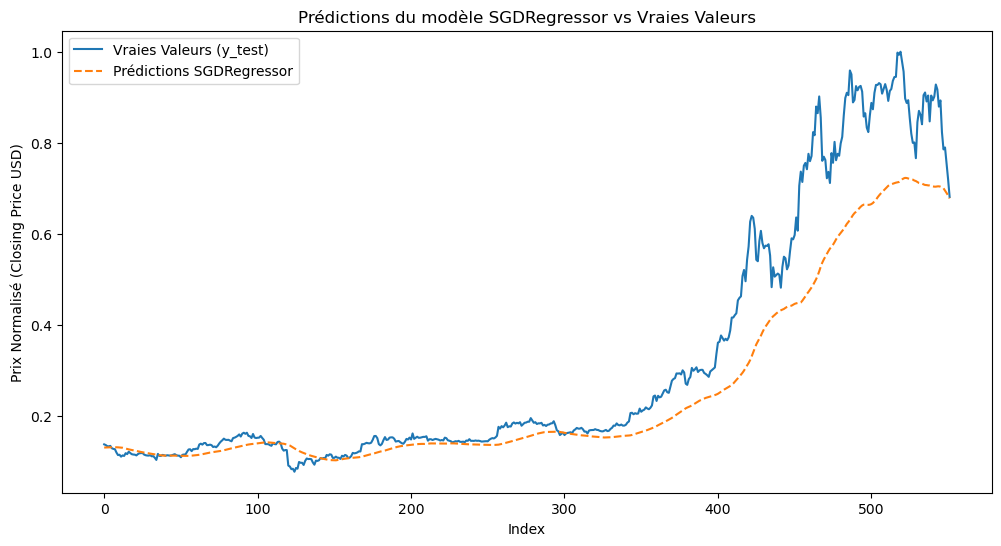

In [148]:
# Visualiser les prédictions du modèle Incrémental
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Vraies Valeurs (y_test)')
plt.plot(y_pred_sgd, label='Prédictions SGDRegressor', linestyle='dashed')
plt.title('Prédictions du modèle SGDRegressor vs Vraies Valeurs')
plt.xlabel('Index')
plt.ylabel('Prix Normalisé (Closing Price USD)')
plt.legend()
plt.savefig('apprentissage incremental.png', dpi=300)
plt.show()


In [ ]:
Dans notre cas nous pouvons dire que l'apprentissage incrémental est beaucoup plus performant que les LSTM